In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.stats import t
from bisect import bisect
import scipy.io
import copy
from scipy.stats import norm
import numpy.matlib
%matplotlib inline
print 'success'

success


In [2]:
"""
This notebook implements the Logistic Regression in the 
"Cutting the Metropolis Hastings Budget" framework. 

The target distribution is the posterior for a logistic regression
model trained on MNIST dataset for classifying digits 7 vs 9. The 
dataset consisted of 12007 datapoints. 
"""

# get input data
mat = scipy.io.loadmat('minist7vs1.mat')
TrainLabel = mat['TrainLabel']
TrainLabel = np.reshape(TrainLabel, TrainLabel.shape[1],1)
TrainImg = mat['TrainImg']
TestImg = mat['TestImg']
TestLabel = mat['TestLabel']
print TrainLabel.shape
print TrainImg.shape
print TrainImg[0].shape
TestLabel = np.reshape(TestLabel, TestLabel.shape[1],1)

(12007,)
(12007, 784)
(784,)


In [5]:
"""
Cutting the Metropolis Hastings Budget Method
"""
def random_walk_proposer(beta_t, sigmarw):
    """
    Input: beta_t  : previous parameters, 1-D array
           sigmarw : standard deviation, 1-D array
    """
    res = (np.random.multivariate_normal(beta_t, np.diag(sigmarw))).reshape((len(beta_t),))
    return res

def ll_data(beta_t, beta_n, X, Y):
    p_x_beta_t = 1/(1 + exp(-1* Y*np.dot(beta_t,X)))
    p_x_beta_n = 1/(1 + exp(-1* Y*np.dot(beta_n,X)))
    return log(p_x_beta_n) - log(p_x_beta_t)

def eval_U0(N):
    u = np.random.random()
    return 1/N*log(u)

def make_decision(l_list, N, U0):
    n = float(len(l_list))
    l_mean = sum(l_list)/n
    l_sq = ((np.array(l_list))**2).tolist()
    l_sq_mean = sum(l_sq)/n
    sl = sqrt((l_sq_mean - l_mean*l_mean)*n/(n-1))
    s = sl/sqrt(n) * sqrt(1 - (n-1)/(N-1))
    t_stats = abs((l_mean - U0)/s)
    delta = 1 - t.cdf(t_stats, n-1)
    return delta
    
def generate_parameter(beta_t, N, sigmarw, X, Y, batchsize, epsilon ):
    U0 = eval_U0(N)
    # generate new parameter
    P = len(X[0])
    sigma = (np.matlib.repmat(sigmarw, P,1)).reshape(P,)
    beta_n = random_walk_proposer(beta_t, sigma)
    
    # make decision
    l_list = []
    for i in range(batchsize):
        mid = ll_data(beta_t, beta_n, X[i], Y[i])
        l_list.append(mid)
    
    pos = batchsize
    delta = make_decision(l_list, N, U0)
    while (delta>epsilon) and (pos < N-1):
        mid = ll_data(beta_t, beta_n, X[pos], Y[pos])
        l_list.append(mid)
        pos = pos + 1
        delta = make_decision(l_list, N, U0)
    
    l_mean = sum(l_list)/float(len(l_list))
    if l_mean > U0:
        return (beta_n,1,pos)
    else:
        return (beta_t,0,pos)
    
def eval_cost(X,Y,beta):
    N = len(Y)
    sigmoid_accuracy = 1.0/(1.0 + np.exp(-1.0 * Y * np.dot(beta, X.T)))
    accuracy = len((np.where(sigmoid_accuracy>0.5))[0])
    sigmoid = -1.0 * np.log(1.0 + np.exp(-1.0 * Y * np.dot(beta, X.T)))
    cost = np.sum(sigmoid)
    """
    accuracy = 0
    cost = 0
    for i in range(N):
        sigmoid_accuracy = 1/(1 + exp(-1* Y[i]*np.dot(beta,X[i])))
        if sigmoid_accuracy > 0.5 :
            accuracy = accuracy + 1
        sigmoid = -1.0 * np.log(1 + exp(-1 * Y[i] * np.dot(beta, X[i])))
        cost = cost + sigmoid
    """
    return (cost/float(N), accuracy/float(N))
    
def train(X, Y, sigmarw, batchsize, epsilon, niter):
    N = len(Y) # number of total training data
    P = len(X[0]) # parameter dimension
    beta_t = np.ones(P)
    # beta_t = np.random.rand(P)
    cost_list = []
    accept_pos = []
    accuracy_list = []
    for i in range(niter):
        if i % 100 == 0:
            print i
        index = np.random.permutation(N)
        X = X[index]
        Y = Y[index]
        (beta_t, mid, pos) = generate_parameter(beta_t, N, sigmarw, X,Y,batchsize,epsilon)
        (cost,accuracy) = eval_cost(TestImg, TestLabel, beta_t)
        cost_list.append(cost)
        accuracy_list.append(accuracy)
        accept_pos.append(pos)
    return (cost_list, accept_pos, accuracy_list)

X = TrainImg
Y = TrainLabel
sigmarw = 0.01
batchsize = 50
epsilon = 0.02
niter = 1000
(cost_list_xl, accept_pos_xl, accuracy_xl) = train(X, Y, sigmarw, batchsize, epsilon, niter)
print sum(accept_pos_xl)/float(len(accept_pos_xl))
cumulate_datasize_xl = [accept_pos_xl[0]]
cumulate_xl = accept_pos_xl[0]
for i in range(1,len(accept_pos_xl)):
    cumulate_xl += accept_pos_xl[i]
    cumulate_datasize_xl.append(cumulate_xl)

0
100
200
300
400
500
600
700
800
900
1498.27


In [3]:
# model class
# assume binary classes, 1 or -1
class Logistic:
    def __init__(self, num_featurs, totN, proposer = None):
        # init the feature vector
        self.p = num_featurs
        self.proposer = proposer
        self.N = totN  # tot number of datas
    
    def ll(self, feature, X, Y):
        # return the log likelihood
        res = 0.0
        [n, p] = X.shape
        n1 = Y.shape[0]
        assert p == self.p
        assert n1 == n
        for i in range(n):
            res += np.log(1.0 + np.exp(-1.0 * Y[i] * np.sum(feature * X[i,:])))
        res = res * (-1.0)
        return res / n
    
    def delta(self, f_old, f_new, X, Y, t):
        # t is the temperature
        res = self.ll(f_new, X, Y) * self.N / t - self.ll(f_old, X, Y) * self.N / t
        res += self.proposer.probGenerate(f_new, f_old, X, Y) # new -> old
        res = res - self.proposer.probGenerate(f_old, f_new, X, Y)  # old -> new
        return res
    
    def grad(self, feature, X, Y):
        # compute the grad of the ll
        [n, p] = X.shape
        n1 = Y.shape[0]
        res = np.zeros(self.p)
        assert p == self.p
        assert n1 == n
        for i in range(n):
            res += Y[i] * X[i,:] / (1 + np.exp(Y[i] * np.sum(feature * X[i,:])))
        return res/ n
    def predAcc(self, f, X, Y):
        [n, p] = X.shape
        n1 = Y.shape[0]
        assert p == self.p
        assert n1 == n
        N_correct = 0
        for i in range(n):
            p = 1.0 / (1 + np.exp(-1.0 * np.sum(f * X[i,:])))
            if p > 0.5 and Y[i] == 1.0:
                N_correct += 1.0
            elif p < 0.5 and Y[i] == -1.0:
                N_correct += 1.0
        return N_correct / n
    def pred(self, f, X):
        a = X.shape
        if len(a) == 1:
            p = 1.0 / (1 + np.exp(-1.0 * np.sum(f * X)))
            if p > 0.5:
                return 1.0
            else:
                return -1.0
        else:
            [n, p] = X.shape
        res = np.zeros(n)
        for i in range(n):
            p = 1.0 / (1 + np.exp(-1.0 * np.sum(f * X[i,:])))
            if p > 0.5:
                res[i] = 1.0
            else:
                res[i] = -1.0
        return res

In [39]:
def randomPropose(beta, sig):
    p = len(beta)
    res = np.zeros(p)
    res = beta + np.random.normal(0,sig, p)
    return res

def randomData(miniBatchSize, im, label):
    n = label.shape[0]
    id = np.random.choice(n, miniBatchSize)
    img = im[id,:]
    idx = label[id]
    return (img, idx)
# this function will return a xcorr val 
def getRandXcorr(ecdf, sdvect, estimatedSd):
    index = bisect(sdvect, estimatedSd) + 1
    x = ecdf[0,:]
    f = ecdf[index, :]
    u = np.random.random()
    return x[bisect(f, u)]
mat = scipy.io.loadmat('../generateXcorr/XcorrCurves.mat')
ecdfmat = mat['res']
sd_vect = mat['sdval']


(array([   7.,   14.,   22.,   69.,  377.,  399.,   75.,   17.,   14.,    6.]),
 array([ -9.98500000e+00,  -7.98750000e+00,  -5.99000000e+00,
         -3.99250000e+00,  -1.99500000e+00,   2.50000000e-03,
          2.00000000e+00,   3.99750000e+00,   5.99500000e+00,
          7.99250000e+00,   9.99000000e+00]),
 <a list of 10 Patch objects>)

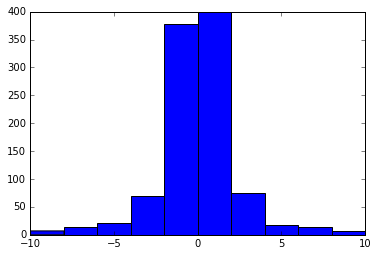

In [54]:
xcorr = np.zeros(1000)
for i in range(1000):
    xcorr[i] = getRandXcorr(ecdfmat, sd_vect, 1.1)
plt.hist(xcorr)

In [5]:
class LangvanProposer:
    def __init__(self, model):
        self.m = model
        self.step = 1.0
    def setStepSize(self, s):
        self.step = s
        
    def update(self, beta, X, Y):
        beta1 = beta + self.step / 2.0 * self.m.grad(beta, X, Y)
        # add the noise
        p = len(beta1)
        beta1 = beta1 + np.random.normal(0, self.step**0.5, p)
        return beta1
    
    def probGenerate(self, beta_old, beta_new, X, Y):
        # beta_old -> beta_new
        beta_tmp = beta_old + self.step / 2.0 * self.m.grad(beta_old, X, Y)
        # find the diff
        diff = beta_tmp - beta_new
        res = -1.0 * np.sum(diff**2.0) / 2.0 / self.step
        return res
        
class RandomWalkProposer:
    def update(self, beta, sig):
        p = len(beta)
        res = np.zeros(p)
        res = beta + np.random.normal(0,sig, p)
        return res
    def probGenerate(self, beta_old, beta_new, X, Y):
        return 1.0

class NoiseGradDescentProposer:
    def __init__(self, model, sd):
        self.m = model
        self.sd = sd
        self.step = 1.0
    def setStepSize(self, s):
        self.step = s
        
    def update(self, beta, X, Y):
        beta1 = beta + self.step / 2.0 * self.m.grad(beta, X, Y)
        # add the noise
        p = len(beta1)
        beta1 = beta1 + np.random.normal(0, self.sd, p)
        return beta1
    
    def probGenerate(self, beta_old, beta_new, X, Y):
        # beta_old -> beta_new
        beta_tmp = beta_old + self.step / 2.0 * self.m.grad(beta_old, X, Y)
        # find the diff
        diff = beta_tmp - beta_new
        res = -1.0 * np.sum(diff**2.0) / 2.0 / self.sd**2
        return res

In [29]:
print TrainImg.shape, TrainLabel.shape

(12007, 784) (12007,)


In [100]:
# try the mini_batch
N = 8000
p = 784
# beta = np.random.rand(p)
beta = np.ones(p)
rd = RandomWalkProposer()
sig0 = 0.1
logm = Logistic(p, 12007, rd)
sd_est = 0
sd_array = np.ones(N)
miniBatchSize = 50
num_sd = 10
ll = []
acc = []
ll_full = np.zeros(N)
acc_full = np.zeros(N)
T0 = 3000.0

for i in range(N):
    sd_vect = np.zeros(num_sd)
    if i > N /2:
        T = T0 / (i + 1.0)**2.0
    else:
        T = T0 / (i + 1.0) ** 0.2
    # sig = sig0 / (i + 1.0)**0.5
    T =T0
    sig = sig0
    
    for j in range(num_sd):
        data = randomData(miniBatchSize, TrainImg, TrainLabel)
        beta1 = rd.update(beta, sig)
        sd_vect[j] = logm.delta(beta, beta1, data[0], data[1], T)
    sd_est = sd_est *0.7 + np.std(sd_vect) *0.3
    u = np.random.random()
    sd_array[i] = sd_est
    if sd_est > 1.2:
        ll_full[i] = logm.ll(beta, TestImg[0:1000,:], TestLabel[0:1000])
        acc_full[i] = logm.predAcc(beta, TestImg[0:1000,:], TestLabel[0:1000])
        print sd_est
        continue
    # X_log = ecdf_l[bisect(x_l, u)]
    x_c = getRandXcorr(ecdfmat, sd_vect,sd_est)
    beta1 = rd.update(beta, sig)
    data = randomData(miniBatchSize, TrainImg, TrainLabel)
    delta = logm.delta(beta, beta1, data[0], data[1], T)
    if i % 500 == 0:
        print i
    if (delta + x_c > 0):
        beta = beta1
    # data = randomData(200, TestImg, TestLabel)
    # ll.append(logm.ll(beta, data[0], data[1]))
    # acc.append(logm.predAcc(beta, data[0], data[1]))
    ll_full[i] = logm.ll(beta, TestImg[0:1000,:], TestLabel[0:1000])
    acc_full[i] = logm.predAcc(beta, TestImg[0:1000,:], TestLabel[0:1000])

0
1.25797265578
1.47455321644
1.29602310944
1.27398420911
1.23178627631
1.23071709793
1.21485177617
1.20559839163
1.39992781629
1.38168979102
1.33695918401
1.27102174904
1.31820397505
1.2278328353
1.27333040761
1.23811865637
1.35354823419
1.29002179372
1.23111572862
1.25456534043
1.33569212541
1.22071958252
1.22392077768
1.31405436954
1.37814585375
1.23330059714
1.23530985602
1.25625070486
1.20156542895
1.26691809403
1.37929385202
1.29995192248
1.34546885674
1.40754591505
1.32758726684
1.36695465152
1.3056128749
1.29740791044
1.25071527939
1.21803304988
1.39230499192
1.3484797865
1.24167779804
1.25400102365
1.26781640683
1.21370138471
1.23015906569
1.20923080811
1.20615121118
1.27467207342
1.24909218326
1.38010325009
1.24949610998
1.22083692685
1.21832738889
1.23344554754
1.2640270501
1.21696112389
1.20265606852
1.28365599736
1.25487074697
1.21875681464
1.21883992326
1.42836643176
1.46792655565
1.46517888055
1.48602996298
1.52334166095
1.4473107662
1.33365793925
1.27934374295
1.2873121

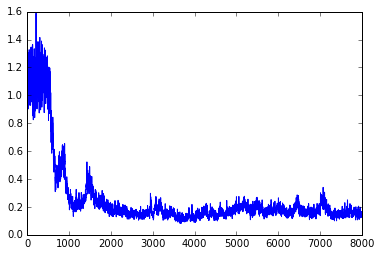

0.257726302271


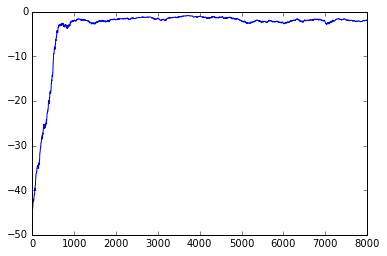

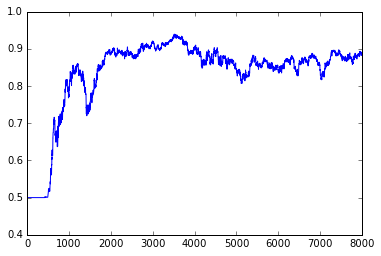

In [93]:
plt.plot(sd_array)
plt.show()
print np.mean(sd_array)
plt.plot(ll_full)
plt.show()
plt.plot(acc_full)

In [79]:
ll_full_final = ll_full
acc_full_final = acc_full

In [85]:
previousRes = scipy.io.loadmat('xl0_ones_hyc_final.mat')
cumulate_datasize_xl = previousRes['cumulate_datasize_xl'][0]
cost_list_xl = previousRes['cost_list_xl'][0]
accuracy_xl = previousRes['accuracy_xl'][0]


In [84]:
print accuracy_xl[0].shape

(1000,)


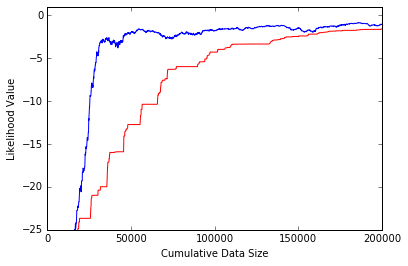

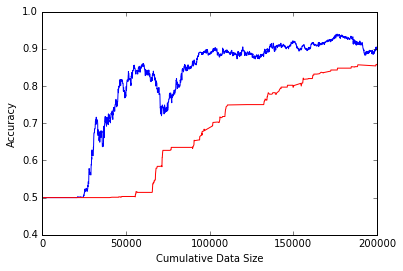

In [98]:
plt.figure()
#plt.plot(cumulate_datasize_xl,cost_list_xl,'r')
#plt.hold(True)
x_ax = np.ones(N) * miniBatchSize
x_ax = np.cumsum(x_ax)
plt.plot(x_ax, ll_full, 'b')
plt.plot(cumulate_datasize_xl,cost_list_xl,'r')
plt.xlabel('Cumulative Data Size')
plt.ylabel('Likelihood Value')
plt.axis([-1,200000,-25,1])

# plt.savefig('ll_hyc.png')
plt.show()


# plot the accuracy with respect to the cumulative data size
plt.figure()
#plt.plot(cumulate_datasize_xl, accuracy_xl, 'r')
#plt.hold(True)
plt.plot(x_ax, acc_full, 'b')
plt.plot(cumulate_datasize_xl, accuracy_xl, 'r')
plt.xlabel('Cumulative Data Size')
plt.ylabel('Accuracy')
plt.axis([0, 200000 ,0.4, 1])

# plt.savefig('acc_hyc.png')
plt.show()

In [18]:
# non-temperature case:
# try the mini_batch
N = 8000
p = 784
# beta = np.random.rand(p)
beta = np.ones(p)
rd = RandomWalkProposer()
sig0 = 0.1
logm = Logistic(p, 12007, rd)
sd_est = 0
sd_array = np.zeros(N)
miniBatchSize = 50
num_sd = 10
#ll = []
#acc = []
ll_full_nonT = np.zeros(N)
acc_full_nonT = np.zeros(N)
T0 = 10.0
for i in range(N):
    sd_vect = np.zeros(num_sd)
    T = 1.0
    # sig = sig0 / (i + 1.0)**0.5
    sig = sig0
    for j in range(num_sd):
        data = randomData(miniBatchSize, TrainImg, TrainLabel)
        beta1 = rd.update(beta, sig)
        sd_vect[j] = logm.delta(beta, beta1, data[0], data[1], T)
    sd_est = sd_est *0.7 + np.std(sd_vect) *0.3
    u = np.random.random()
    sd_array[i] = sd_est
    # X_log = ecdf_l[bisect(x_l, u)]
    x_c = x_corr[bisect(ecdf_corr, u)]
    x_c = x_c *sd_est
    beta1 = rd.update(beta, sig)
    data = randomData(miniBatchSize, TrainImg, TrainLabel)
    delta = logm.delta(beta, beta1, data[0], data[1], T)
    if i % 500 == 0:
        print i
    if (delta + x_c > 0):
        beta = beta1
    # data = randomData(200, TestImg, TestLabel)
    # ll.append(logm.ll(beta, data[0], data[1]))
    # acc.append(logm.predAcc(beta, data[0], data[1]))
    ll_full_nonT[i] = logm.ll(beta, TestImg[0:1000,:], TestLabel[0:1000])
    acc_full_nonT[i] = logm.predAcc(beta, TestImg[0:1000,:], TestLabel[0:1000])

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500


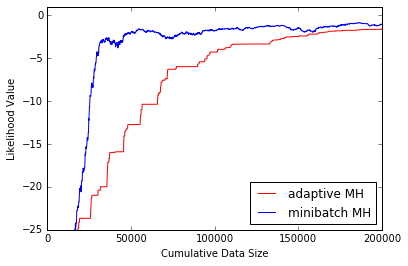

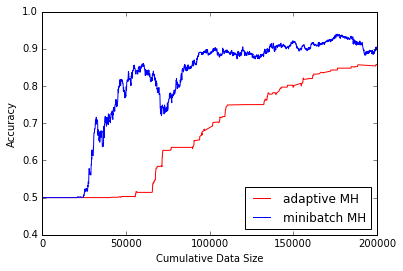

In [99]:
"""
compare the result
"""
# plot the likelihood with respect to the cumulative data size
plt.figure()
line_up, = plt.plot(cumulate_datasize_xl,cost_list_xl,'r')
plt.hold(True)
x_ax = np.ones(N) * miniBatchSize
x_ax = np.cumsum(x_ax)
line_mid, = plt.plot(x_ax, ll_full, 'b')
# line_down, = plt.plot(x_ax, ll_full_nonT, 'y')
plt.xlabel('Cumulative Data Size')
plt.ylabel('Likelihood Value')
plt.axis([-1,200000,-25,1])

plt.legend([line_up, line_mid] , ['adaptive MH', 'minibatch MH'],  loc='lower right')

plt.savefig('ll_hyc.png')
plt.show()


# plot the accuracy with respect to the cumulative data size
plt.figure()
line_up , = plt.plot(cumulate_datasize_xl, accuracy_xl, 'r')
plt.hold(True)
line_mid, = plt.plot(x_ax, acc_full, 'b')
# line_down, = plt.plot(x_ax, acc_full_nonT, 'y')
plt.xlabel('Cumulative Data Size')
plt.ylabel('Accuracy')
plt.axis([0, 200000 ,0.4, 1])

plt.legend([line_up, line_mid],  ['adaptive MH', 'minibatch MH'],  loc='lower right')

plt.savefig('acc_hyc.png')
plt.show()

In [63]:
scipy.io.savemat('xl0_ones_hyc_final.mat',{'cumulate_datasize_xl':cumulate_datasize_xl, 'cost_list_xl':cost_list_xl, 'accuracy_xl':accuracy_xl})
scipy.io.savemat('hy0_ones_hyc_final.mat',{'x_ax':x_ax, 'll_full':ll_full, 'll_full_nonT':ll_full_nonT, 'acc_full':acc_full, 'acc_full_nonT':acc_full_nonT})